# MNIST Classification

We will build a dense neural network to classify images and apply it to the classical problem of the classification of the hand-written digits in the MNIST dataset.

## The MNIST dataset

The MNIST dataset consists of grayscale images of handwritten digits from 0 to 9. Each image is 28 pixels by 28 pixels. There are 60,000 training images and 10,000 test images.

We have organized these images in two folders named `train` and `test`:

> train/0_000000.png<br>
> train/0_000001.png<br>
> ...<br>
> train/1_000000.png<br>
> ...<br>

> test/0_000000.png<br>
> ...<br>
> test/1_000000.png<br>
> ...<br>

The first digit in the filename is the label.

In [ ]:
import os

# downloads the repository containing the MINST dataset 
# only if the MNIST_dataset directory is empty
os.system("git clone https://github.com/DeepTrackAI/MNIST_dataset")

train_path = os.path.join("MNIST_dataset", "mnist", "train")
test_path = os.path.join("MNIST_dataset", "mnist", "test")

train_images_paths = os.listdir(train_path)
test_images_paths = os.listdir(test_path)

print(f"{len(train_images_paths)} training images")
print(f"{len(test_images_paths)} test images")

We can use `matplotlib` to load the images into `numpy` arrays. Since the `mnist` dataset is small enough to be contained in memory, we can load all images at once. For larger datasets, we would need to load the images as needed during training.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_images = []
for path in train_images_paths:
    image = plt.imread(os.path.join(train_path, path))
    train_images.append(image)

test_images = []
for path in test_images_paths:
    image = plt.imread(os.path.join(test_path, path))
    test_images.append(image)

print(f"{len(train_images)} training images with shape {train_images[0].shape}")
print(f"{len(test_images)} test images with shape {test_images[0].shape}")

Since the digit is encoded as the first character of the filename, we can extract the ground-truth labels from the filenames.

In [ ]:
train_ground_truth = []
for path in train_images_paths:
    filename = os.path.basename(path)
    digit = int(filename[0])
    train_ground_truth.append(digit)

test_ground_truth = []
for path in test_images_paths:
    filename = os.path.basename(path)
    digit = int(filename[0])
    test_ground_truth.append(digit)

print(f"{len(train_ground_truth)} training ground-truth digits")
print(f"{len(test_ground_truth)} test ground-truth digits")

We can now visualize some of the MNIST digits.

In [ ]:
indexes_of_images_to_show = np.linspace(0, 60000, 18, dtype=int, endpoint=False)

plt.figure(figsize=(15, 9))

for i in range(18):
    data_index = indexes_of_images_to_show[i]
    train_image = train_images[data_index]
    train_groundtruth = train_ground_truth[data_index]

    plt.subplot(3, 6, i + 1)
    plt.title(f"Label: {train_groundtruth}", fontsize=20)
    plt.imshow(train_image.squeeze(), cmap="Greys") 
    plt.axis("off")

plt.tight_layout()
plt.show()

## First Neural Network

We will create the neural network using `deeplay`.

### Neural Network Model

We will start with a small _dense neural network_ (often called also _multi-layer perceptron_ or _fully connected neural network_) with 784 = 28 x 28 inputs (one for each pixel, `.in_features(28 * 28)`), two hidden layers with 32 neurons each (`.hidden_dims([32, 32])`) with _sigmoid_activation (`.blocks.activation(Sigmoid)`), and an output layer with 10 neurons (`.out_features(10)`) with _sigmoid_ activation (one for each digit, `.out_activation(Sigmoid)`). 

The output will be a vector of 10 numbers between 0 and 1, which can be loosely interpreted as probabilities, so that the predicted digit is the one with the highest output value.

In [ ]:
import deeplay as dl
from torch.nn import Sigmoid

mlp_config = (dl.Config()
    .in_features(28 * 28)
    .hidden_dims([32, 32])
    .blocks.activation(Sigmoid)
    .out_features(10)
    .out_activation(Sigmoid)
    .blocks.activation(Sigmoid)
)
mlp_model = dl.MultiLayerPerceptron.from_config(mlp_config)

print(mlp_model)
print(f"{sum(p.numel() for p in mlp_model.parameters())} trainable parameters")

### Application as Classifier

We use the `Classifier` application class from `deeplay` to define what we want to do with the neural network (e.g., determining the training logic and adding some convenient metrics such as accuracy).

We add to the classifier the model we have jsut created (`.model(dt.MultiLayerPerceptron, mlp_config)`). Then, we set the numebr of classes (`.num_classes(10)`), convert the ground-truth labels to one-hot vectors to match the output of the model (`.make_target_onehot(True)`), set the mean squared error as loss function (`.loss(MSELoss)`), and set stochastic gradient descent as optimizer with learning rate `lr=0.1` (`.optimizer(SGD, lr=0.1)`).

In [ ]:
from torch.nn import MSELoss
from torch.optim import SGD

classifier_config = (dl.Config()
    .model(dl.MultiLayerPerceptron, mlp_config)
    .num_classes(10)
    .make_target_onehot(True)
    .loss(MSELoss)
    .optimizer(SGD, lr=0.1)
)
classifier = dl.Classifier.from_config(classifier_config)
    
print(classifier)

**Note**

The config above is equivalent to the following, where the properties of the neural network model are set explicitly.

```python
classifier_config = (
    dl.Config()
    .model(dl.MultiLayerPerceptron)
    .model.in_features(28 * 28)
    .model.hidden_dims([32, 32])
    .model.out_features(10)
    .model.out_activation(Sigmoid)
    .model.blocks.activation(Sigmoid)
    .num_classes(10)
    .make_targets_onehot(True)
    .loss(MSELoss)
    .optimizer(SGD, lr=0.1)
)
```

### Dataloader

A `DataLoader` object manages the data to be passed to the neural network. The simplest way to create a dataloader from data already in memory is to create a list of `(sample, ground_truth)` tuples. This can easily be achieved using the Python native function `zip()`.

In [ ]:
train_mnist_image_and_groundtruth = list(zip(train_images, train_ground_truth))
test_mnist_image_and_groundtruth = list(zip(test_images, test_ground_truth))

mnist_train_dataloader = dl.DataLoader(train_mnist_image_and_groundtruth, shuffle=True) # important to shuffle the data - try out what happens if you do not
mnist_test_dataloader = dl.DataLoader(test_mnist_image_and_groundtruth, shuffle=False)

print(f"{len(mnist_train_dataloader)} training batches")
print(f"{len(mnist_test_dataloader)} test batches")

### Trainer

A `Trainer` object manages the training and evaluation, e.g., deciding what hardware to use, when to stop training, whether to utilize the GPU, and when to save the model, log the training, and evaluate metrics. 

For now, we will create a trainer for a single epoch (an epoch is a single pass through the entire training set, `max_epochs=1`) and with automatic hardware acceleration (it will use a GPU if available, otherwise a CPU, `accelerator="auto`).

In [ ]:
trainer = dl.Trainer(
    max_epochs=1,
    accelerator="auto", 
)

### Training

In [ ]:
trainer.fit(classifier, mnist_train_dataloader)

Let's check the test set. We can reuse the trainer to test the model on the test set:

### Testing

In [11]:
trainer.test(classifier, mnist_test_dataloader)

### Confusion Matrix

A _confusion matrix_ can be used to visualize the performance of a classifier. It indicates what errors the neural network makes and to gain insights that can help us improve its architecture and training hyperparameters. 

A confusion matrix is a square matrix with a number of rows and columns equal to the number of classes in the classification problem, here 10. 
Each row and column corresponds to one class in the classification problem, ordered arbitrarily but equally for the two axes. 
In this case, we have a natural ordering of the classes, which is the order of the digits. 
An element c_i,j of the confusion matrix represents the number of times the neural network assigned the predicted class j to the actual class i. For example, in our case, c_3,5 would correspond to the number of times the neural network, when given an image depicting the digit 3, classified it as the digit 5. The name stems from the fact that this representation makes it easy to see which classes the model is most commonly confusing.

 Here, we have chosen to assign the `groundtruth_digit` to the second axis and `predicted_digit` to the first axis, but the opposite is also a valid (and comon) choice.

In [12]:
import matplotlib.pyplot as plt
from seaborn import heatmap, cubehelix_palette
from numpy import zeros

trainer.predict

# Compute the confusion matrix
def plot_confusion_matrix(model, trainer, dataloader):
    confusion_matrix = zeros((10, 10), dtype=int)

    for image, groundtruth_digits in dataloader:
        predicted_probabilities = model(image)
        max_probability, predicted_digits = predicted_probabilities.max(dim=1)
        
        # np.add.at is a function that allows us to add values to a numpy array at specific indices
        # Unlike arr[indices] += 1, np.add.at(arr, indices, 1) handles the case where there are duplicate indices.
        # So, arr[[0, 0]] += 1 would result in arr[0] = 1, but np.add.at(arr, [0, 0], 1) results in arr[0] = 2 
        np.add.at(confusion_matrix, (groundtruth_digits, predicted_digits), 1)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    heatmap(
        confusion_matrix,
        annot=True, 
        fmt=".0f", 
        square=True, 
        cmap=cubehelix_palette(light=0.95, as_cmap=True),
        vmax=150,
    )
    plt.xlabel("Predicted digit", fontsize=15)
    plt.ylabel("Ground truth digit", fontsize=15)
    plt.show()
    
plot_confusion_matrix(classifier, trainer, mnist_test_dataloader)

## Neural Network Improvements

We now start a journey to improve our network and its training, as is usual in developing machine-learning solutions.
We will gradually introduce some new (and fundametal) concepts, to demonstrate how they affect the performance of the trained network, which provide valuable intuition for what hyperparameters are relevant.

### Output Representation

Currently each digit is assigned a probability between 0 and 1 by the network. However, we know that only one classification is true. As such, we can normalize the output such that the prediction sums to one. By doing so, we impose our prior knowledge to reduce the complexity of the problem. This is typically done using what is known as _softmax activation_.

In [13]:
from torch.optim import RMSprop
import torch

classifier_config_with_softmax_out = (
    classifier_config
    .model.out_activation(torch.nn.Softmax, dim=1)
)

classifier = dl.Classifier.from_config(classifier_config_with_softmax_out)
print(classifier)

trainer = dl.Trainer(
    max_epochs=1,
    accelerator="auto", 
)

trainer.fit(classifier, mnist_train_dataloader)
trainer.test(classifier, mnist_test_dataloader)

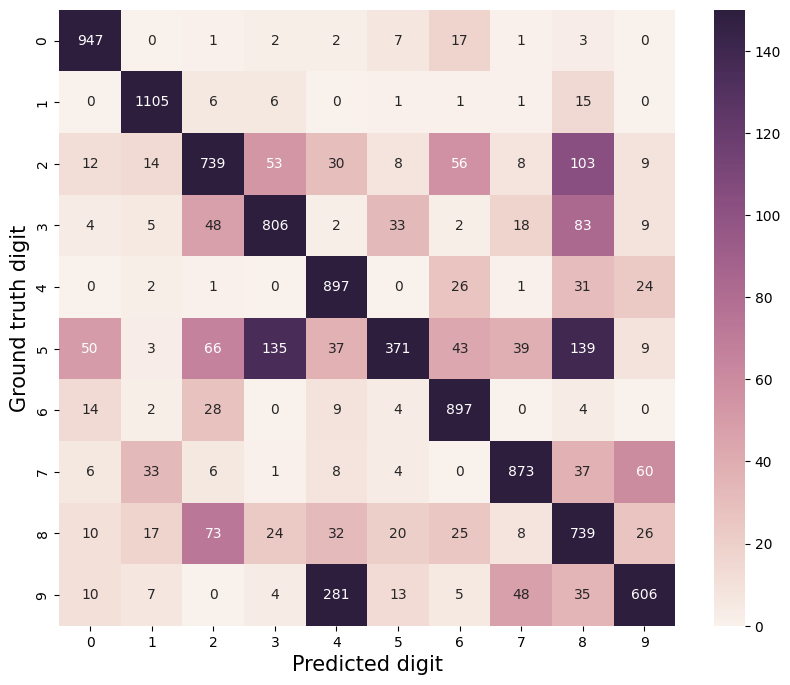

In [14]:
plot_confusion_matrix(classifier, trainer, mnist_test_dataloader)

In [15]:
classifier_config_with_relu_internal = (
    classifier_config_with_softmax_out
    .model.blocks.activation(torch.nn.ReLU)
)

classifier = dl.Classifier.from_config(classifier_config_with_relu_internal)
print(classifier)

trainer = dl.Trainer(
    max_epochs=1,
    accelerator="auto", 
)

trainer.fit(classifier, mnist_train_dataloader)
trainer.test(classifier, mnist_test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                 | Params
-------------------------------------------------------
0 | model         | MultiLayerPerceptron | 26.5 K
1 | loss          | MSELoss              | 0     
2 | train_metrics | ModuleList           | 0     
3 | val_metrics   | ModuleList           | 0     
-------------------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)


Classifier(
  (make_target_onehot): True
  (model): MultiLayerPerceptron(
    (in_features): 784
    (hidden_dims): [32, 32]
    (out_features): 10
    (blocks): ModuleList(
      (0): Template(
        (layer): Linear(in_features=784, out_features=32, bias=True)
        (normalization): Identity()
        (activation): ReLU()
        (dropout): Identity()
      )
      (1): Template(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (normalization): Identity()
        (activation): ReLU()
        (dropout): Identity()
      )
    )
    (out_layer): Linear(in_features=32, out_features=10, bias=True)
    (out_activation): Softmax(dim=1)
  )
  (loss): MSELoss()
  (train_metrics): ModuleList(
    (0): MulticlassAccuracy()
  )
  (val_metrics): ModuleList(
    (0): MulticlassAccuracy()
  )
)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.9315000176429749     │
└───────────────────────────┴───────────────────────────┘

[{'test_MulticlassAccuracy': 0.9315000176429749}]

In [16]:
plot_confusion_matrix(classifier, trainer, mnist_test_dataloader)

### Mini Batches

Let us we will introduce our next improvement: _mini-batches_. Mini-batches are a way to train neural networks using only a subset of the training data at each iteration. This is done by splitting the training data into smaller subsets called _mini-batches_. The neural network is then trained on each mini-batch in turn, and the parameters are updated after each mini-batch. In fact, we were already using mini-batches, but we were using a batch size of one. The batch size is a hyperparameter that can be tuned to improve the performance of the neural network. In general, larger batches can lead to faster training since more data is processed at once, but it demands more memory and might not always lead to better convergence. Moreover, while larger batches yield a better estimate of the local gradient, this does not necessarily correlate to allowing a larger weight update if the optimization landscape is rough. On the other hand, smaller batches can offer a regular update to the model and often lead to a more robust convergence, but the training might be slower due to the overhead of frequent updates. Thus, neither bigger nor smaller batches are universally superior; it's a balance of factors like memory constraints, convergence behavior, and training speed. As a rule of thumb, a batch size of `32` is a good starting point. Rarely are batches smaller than `8` or larger than `256` used.

We set our batch size in our dataloaders. They will handle splitting the data into mini-batches for us. We will use a batch size of `16` for both the training and validation dataloaders. Moreover, since we are now using mini-batches, we can increase the number of epochs to `10` to compensate for the smaller batch size without significantly increasing the total training time.

In [17]:
mnist_test_dataloader = dl.DataLoader(test_mnist_image_and_groundtruth, batch_size=16, shuffle=False)
mnist_train_dataloader = dl.DataLoader(train_mnist_image_and_groundtruth, batch_size=16, shuffle=True)

### Optimizer

Using plain _stochastic gradient descent_ for updating weights is straightforward, but generally not optimal. 
Modern deep learning almost universally uses extensions such as _root mean squared propagation_ (RMSprop) or _Adam_. The main advantages of these alternatives are that they change the learning rate for each weight individually during training. Each algorithm has its own way of doing so, but it is common to use some type of _momentum_. For example, a weight that is updated in the same direction multiple times in a row will take larger steps at each iteration, while a weight that changes direction frequently will take smaller steps. To better utilize our increased batch size, we will use the `RMSprop` optimizer 

In [18]:

config_with_rmsprop = (
    classifier_config_with_relu_internal
    .optimizer(RMSprop, lr=0.001)
)

classifier = dl.Classifier.from_config(config_with_rmsprop)
print(classifier)

trainer = dl.Trainer(
    max_epochs=10,
    accelerator="auto", 
)

trainer.fit(classifier, mnist_train_dataloader)
trainer.test(classifier, mnist_test_dataloader)

In [19]:
plot_confusion_matrix(classifier, trainer, mnist_test_dataloader)

## Failure Analysis

it is often instructive to check for which inputs the network fails. In fact, this can give further insights into what is still difficult for the neural network to classify and, therefore, suggests potential ways to improve its performance.

In [20]:
mnist_test_dataloader = dl.DataLoader(train_mnist_image_and_groundtruth, batch_size=1, shuffle=False)

number_of_images_per_digit_to_show = 10
num_incorrect_predictions_per_digit = np.zeros(10, int)

plt.figure(figsize=(10, number_of_images_per_digit_to_show))

for image, groundtruth_digits in mnist_test_dataloader:
    groundtruth_digits = int(groundtruth_digits)

    if num_incorrect_predictions_per_digit[groundtruth_digits] >= number_of_images_per_digit_to_show:
        continue

    predicted_probabilities = classifier(image)
    max_probability, predicted_digits = predicted_probabilities.max(dim=1)
    if predicted_digits == groundtruth_digits:
        continue 

    num_incorrect_predictions_per_digit[groundtruth_digits] += 1

    subplot_idx = groundtruth_digits * number_of_images_per_digit_to_show + num_incorrect_predictions_per_digit[groundtruth_digits]
    plt.subplot(10, number_of_images_per_digit_to_show, subplot_idx)
    plt.imshow(image.squeeze(), cmap="Greys")
    plt.annotate(str(int(predicted_digits)), (0.8, 1), (1, 1), xycoords="axes fraction", textcoords="offset points", va="top", ha="left", fontsize=20, color="red")
    plt.axis("off")

    if (num_incorrect_predictions_per_digit >= number_of_images_per_digit_to_show).all():
        break

plt.tight_layout()
plt.show()